In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

tf.random.set_seed(42)

2023-03-02 21:33:26.613018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 21:33:29.263126: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/prp/anaconda3/lib/
2023-03-02 21:33:29.263215: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/prp/anaconda3/lib/
2023-03-02 21:33:29.263222: W tensorflow/compiler/tf2tensorrt/utils/py_utils.c

In [2]:
True if(len(tf.config.list_physical_devices('GPU')) > 0) else False

2023-03-02 21:33:33.051394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-02 21:33:33.200270: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-02 21:33:33.200539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


True

In [3]:
def load_data(path, col=None, verbose=False):
    df = pd.read_csv(path)
    if col is not None:
        df = df[col]
    if verbose:
        print(df.head())
    return df

In [4]:
print("Multivariate Sample")
data_path = "/mnt/d/Learning/tensorflow_learning/datasets/DailyDelhiClimateTrain.csv"
df = load_data(data_path)

Multivariate Sample


In [5]:
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [6]:
def clean_data(series):
    """Fills missing values. 
    
        Interpolate missing values with a linear approximation.
    """
    series_filled = series.interpolate(method='linear')
        
    return series_filled
        
    
def min_max_scale(dataframe):
    """ Applies MinMax Scaling
    
        Wrapper for sklearn's MinMaxScaler class.
    """
    mm = MinMaxScaler()
    return mm.fit_transform(dataframe)

In [41]:
def make_time_features(series):
    
    #convert series to datetimes
    times = series.apply(lambda x: x.split('+')[0])
    datetimes = pd.DatetimeIndex(times)
    
    day = datetimes.day.values
    months = datetimes.month.values
    years = datetimes.year.values
    
    dayofw = pd.Series(day, name='dayofw')
    month = pd.Series(months, name='months')
    year = pd.Series(years, name = "years")
    
    return dayofw, month, year

In [42]:
def split_data(series, train_fraq):
    """Splits input series into train, val and test.
    
        Default to 1 year of test data.
    """
    #slice the last year of data for testing 1 year has 8760 hours
    train_val_data = series

    #make train and validation from the remaining
    train_size = int(len(train_val_data) * train_fraq)
    
    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]
    
    return train_data, val_data

In [43]:
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):
    """ Create a windowed tensorflow dataset
    
    """

    #create a window with n steps back plus the size of the prediction length
    window = n_steps + n_horizon
    
    #expand dimensions to 3D to fit with LSTM inputs
    #creat the inital tensor dataset
    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)
    
    #create the window function shifting the data by the prediction length
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    
    #flatten the dataset and batch into the window size
    ds = ds.flat_map(lambda x : x.batch(window))
    ds = ds.shuffle(shuffle_buffer)    
    
    #create the supervised learning problem x and y and batch
    if multi_var:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:, :1]))
    else:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))
    
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

In [76]:
def build_dataset(train_fraq=0.8, n_steps=24, n_horizon=1, batch_size=256, shuffle_buffer=500, expand_dims=False, multi_var=False):
    """If multi variate then first column is always the column from which the target is contstructed.
    """
    
    tf.random.set_seed(23)
    
    if multi_var:
        data = load_data(data_path, col=['date', 'meantemp', 'humidity', "wind_speed", "meanpressure"])
        day, months, years = make_time_features(data.date)
        data = pd.concat([data.drop(['date'], axis=1), day, months, years], axis=1)
    else:
        data = load_data(col=['total load actual'])
        
    data = clean_data(data)
    
    if multi_var:
        mm = MinMaxScaler()
        data = mm.fit_transform(data)
    
    train_data, val_data = split_data(data, train_fraq=train_fraq)
    
    train_ds = window_dataset(train_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    val_ds = window_dataset(val_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    print(f"Prediction lookback (n_steps): {n_steps}")
    print(f"Prediction horizon (n_horizon): {n_horizon}")
    print(f"Batch Size: {batch_size}")
    print("Datasets:")
    print(train_ds.element_spec)
    
    return train_ds, val_ds

In [77]:
def get_params(multivar=False):
    lr = 3e-4
    n_steps=24
    n_horizon=1
    if multivar:
        n_features=7
    else:
        n_features=1
        
    return n_steps, n_horizon, n_features, lr

In [85]:
model_configs = dict()

def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}

def get_callbacks(model_name):
  callbacks = []
  MC = tf.keras.callbacks.ModelCheckpoint(f'saved_models/{model_name}', monitor='val_loss', save_best_only='True', verbose=1)
  ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights='True')
  return [MC, ES]

def run_model(model_name, model_func, model_configs, epochs):
    
    n_steps, n_horizon, n_features, lr = get_params(multivar=True)
    train_ds, val_ds= build_dataset(n_steps=n_steps, n_horizon=n_horizon, multi_var=True)

    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks = get_callbacks(model.name))
    test_ds = val_ds
    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds

In [86]:
def dnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='dnn')
    
    loss=tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model


dnn = dnn_model(*get_params(multivar=True))
dnn.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 168)               0         
                                                                 
 dense (Dense)               (None, 128)               21632     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 38,273
Trainable params: 38,273
Non-trainable par

In [87]:
def cnn_model(n_steps, n_horizon, n_features, lr=3e-4):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="CNN")
    
    loss= tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

cnn = cnn_model(*get_params(multivar=True))
cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19, 64)            2752      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 64)             12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dropout (Dropout)           (None, 192)               0       

In [88]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm = lstm_model(*get_params(multivar=True))
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 72)            23040     
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129    

In [89]:
def lstm_cnn_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_cnn = lstm_cnn_model(*get_params(multivar=True))
lstm_cnn.summary()

Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19, 64)            2752      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 64)             12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 3, 72)             39456     
                                                                 
 lstm_1 (LSTM)               (None, 48)                232

In [90]:
def lstm_cnn_skip_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
   
    inputs = tf.keras.layers.Input(shape=(n_steps,n_features), name='main')
    
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling1D(2)(conv1)
    conv2 = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling1D(2)(conv2)
    lstm_1 = tf.keras.layers.LSTM(72, activation='relu', return_sequences=True)(max_pool_2)
    lstm_2 = tf.keras.layers.LSTM(48, activation='relu', return_sequences=False)(lstm_1)
    flatten = tf.keras.layers.Flatten()(lstm_2)
    
    skip_flatten = tf.keras.layers.Flatten()(inputs)

    concat = tf.keras.layers.Concatenate(axis=-1)([flatten, skip_flatten])
    drop_1 = tf.keras.layers.Dropout(0.3)(concat)
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = tf.keras.layers.Dropout(0.3)(dense_1)
    output = tf.keras.layers.Dense(n_horizon)(drop_2)
    
    model = tf.keras.Model(inputs=inputs, outputs=output, name='lstm_skip')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_skip = lstm_cnn_skip_model(*get_params(multivar=True))
lstm_skip.summary()

Model: "lstm_skip"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main (InputLayer)              [(None, 24, 7)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 19, 64)       2752        ['main[0][0]']                   
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 9, 64)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 7, 64)        12352       ['max_pooling1d[0][0]']          
                                                                                          

In [91]:
model_configs=dict()
run_model("dnn", dnn_model, model_configs, epochs=150)
run_model("cnn", cnn_model, model_configs, epochs=150)
run_model("lstm", lstm_model, model_configs, epochs=150)
run_model("lstm_cnn", lstm_cnn_model, model_configs, epochs=150)
run_model("lstm_skip", lstm_cnn_skip_model, model_configs, epochs=150)

Prediction lookback (n_steps): 24
Prediction horizon (n_horizon): 1
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


Epoch 1/150
      1/Unknown - 1s 819ms/step - loss: 0.6042 - mae: 1.0673
Epoch 1: val_loss improved from inf to 0.12892, saving model to saved_models/dnn
INFO:tensorflow:Assets written to: saved_models/dnn/assets


INFO:tensorflow:Assets written to: saved_models/dnn/assets


5/5 [==============================] - 2s 215ms/step - loss: 0.2697 - mae: 0.6134 - val_loss: 0.1289 - val_mae: 0.4861
Epoch 2/150
3/5 [=================>............] - ETA: 0s - loss: 0.1187 - mae: 0.3941
Epoch 2: val_loss improved from 0.12892 to 0.02209, saving model to saved_models/dnn
INFO:tensorflow:Assets written to: saved_models/dnn/assets


INFO:tensorflow:Assets written to: saved_models/dnn/assets


5/5 [==============================] - 1s 158ms/step - loss: 0.1022 - mae: 0.3617 - val_loss: 0.0221 - val_mae: 0.1871
Epoch 3/150
3/5 [=================>............] - ETA: 0s - loss: 0.0547 - mae: 0.2664
Epoch 3: val_loss did not improve from 0.02209
5/5 [==============================] - 0s 36ms/step - loss: 0.0600 - mae: 0.2806 - val_loss: 0.0704 - val_mae: 0.3600
Epoch 4/150
3/5 [=================>............] - ETA: 0s - loss: 0.0488 - mae: 0.2565
Epoch 4: val_loss improved from 0.02209 to 0.00526, saving model to saved_models/dnn
INFO:tensorflow:Assets written to: saved_models/dnn/assets


INFO:tensorflow:Assets written to: saved_models/dnn/assets


5/5 [==============================] - 1s 153ms/step - loss: 0.0446 - mae: 0.2443 - val_loss: 0.0053 - val_mae: 0.0836
Epoch 5/150
3/5 [=================>............] - ETA: 0s - loss: 0.0295 - mae: 0.1944
Epoch 5: val_loss did not improve from 0.00526
5/5 [==============================] - 0s 34ms/step - loss: 0.0322 - mae: 0.2024 - val_loss: 0.0108 - val_mae: 0.1220
Epoch 6/150
3/5 [=================>............] - ETA: 0s - loss: 0.0299 - mae: 0.1992
Epoch 6: val_loss improved from 0.00526 to 0.00517, saving model to saved_models/dnn
INFO:tensorflow:Assets written to: saved_models/dnn/assets


INFO:tensorflow:Assets written to: saved_models/dnn/assets


5/5 [==============================] - 1s 156ms/step - loss: 0.0289 - mae: 0.1944 - val_loss: 0.0052 - val_mae: 0.0818
Epoch 7/150
3/5 [=================>............] - ETA: 0s - loss: 0.0240 - mae: 0.1759
Epoch 7: val_loss did not improve from 0.00517
5/5 [==============================] - 0s 34ms/step - loss: 0.0229 - mae: 0.1725 - val_loss: 0.0113 - val_mae: 0.1285
Epoch 8/150
3/5 [=================>............] - ETA: 0s - loss: 0.0229 - mae: 0.1691
Epoch 8: val_loss did not improve from 0.00517
5/5 [==============================] - 0s 34ms/step - loss: 0.0218 - mae: 0.1647 - val_loss: 0.0052 - val_mae: 0.0814
Epoch 9/150
3/5 [=================>............] - ETA: 0s - loss: 0.0174 - mae: 0.1477
Epoch 9: val_loss improved from 0.00517 to 0.00438, saving model to saved_models/dnn
INFO:tensorflow:Assets written to: saved_models/dnn/assets


INFO:tensorflow:Assets written to: saved_models/dnn/assets


5/5 [==============================] - 1s 161ms/step - loss: 0.0178 - mae: 0.1480 - val_loss: 0.0044 - val_mae: 0.0735
Epoch 10/150
3/5 [=================>............] - ETA: 0s - loss: 0.0172 - mae: 0.1464
Epoch 10: val_loss did not improve from 0.00438
5/5 [==============================] - 0s 39ms/step - loss: 0.0168 - mae: 0.1446 - val_loss: 0.0074 - val_mae: 0.1014
Epoch 11/150
3/5 [=================>............] - ETA: 0s - loss: 0.0166 - mae: 0.1453
Epoch 11: val_loss did not improve from 0.00438
5/5 [==============================] - 0s 37ms/step - loss: 0.0158 - mae: 0.1419 - val_loss: 0.0092 - val_mae: 0.1148
Epoch 12/150
3/5 [=================>............] - ETA: 0s - loss: 0.0142 - mae: 0.1343
Epoch 12: val_loss did not improve from 0.00438
5/5 [==============================] - 0s 35ms/step - loss: 0.0142 - mae: 0.1342 - val_loss: 0.0048 - val_mae: 0.0799
Epoch 13/150
3/5 [=================>............] - ETA: 0s - loss: 0.0143 - mae: 0.1311
Epoch 13: val_loss did not 

Epoch 1/150


2023-03-02 22:17:47.843496: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-02 22:17:50.326417: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


      5/Unknown - 7s 24ms/step - loss: 0.1177 - mae: 0.3965
Epoch 1: val_loss improved from inf to 0.02769, saving model to saved_models/CNN


INFO:tensorflow:Assets written to: saved_models/CNN/assets


INFO:tensorflow:Assets written to: saved_models/CNN/assets


5/5 [==============================] - 8s 284ms/step - loss: 0.1177 - mae: 0.3965 - val_loss: 0.0277 - val_mae: 0.1783
Epoch 2/150
3/5 [=================>............] - ETA: 0s - loss: 0.0475 - mae: 0.2411
Epoch 2: val_loss did not improve from 0.02769
5/5 [==============================] - 0s 35ms/step - loss: 0.0424 - mae: 0.2285 - val_loss: 0.0478 - val_mae: 0.2814
Epoch 3/150
3/5 [=================>............] - ETA: 0s - loss: 0.0342 - mae: 0.2154
Epoch 3: val_loss improved from 0.02769 to 0.01440, saving model to saved_models/CNN


INFO:tensorflow:Assets written to: saved_models/CNN/assets


INFO:tensorflow:Assets written to: saved_models/CNN/assets


5/5 [==============================] - 1s 203ms/step - loss: 0.0307 - mae: 0.2032 - val_loss: 0.0144 - val_mae: 0.1439
Epoch 4/150
3/5 [=================>............] - ETA: 0s - loss: 0.0205 - mae: 0.1578
Epoch 4: val_loss improved from 0.01440 to 0.00762, saving model to saved_models/CNN


INFO:tensorflow:Assets written to: saved_models/CNN/assets


INFO:tensorflow:Assets written to: saved_models/CNN/assets


5/5 [==============================] - 1s 200ms/step - loss: 0.0200 - mae: 0.1540 - val_loss: 0.0076 - val_mae: 0.1001
Epoch 5/150
3/5 [=================>............] - ETA: 0s - loss: 0.0175 - mae: 0.1468
Epoch 5: val_loss did not improve from 0.00762
5/5 [==============================] - 0s 36ms/step - loss: 0.0162 - mae: 0.1414 - val_loss: 0.0094 - val_mae: 0.1136
Epoch 6/150
3/5 [=================>............] - ETA: 0s - loss: 0.0134 - mae: 0.1311
Epoch 6: val_loss improved from 0.00762 to 0.00702, saving model to saved_models/CNN


INFO:tensorflow:Assets written to: saved_models/CNN/assets


INFO:tensorflow:Assets written to: saved_models/CNN/assets


5/5 [==============================] - 1s 200ms/step - loss: 0.0131 - mae: 0.1299 - val_loss: 0.0070 - val_mae: 0.0928
Epoch 7/150
3/5 [=================>............] - ETA: 0s - loss: 0.0113 - mae: 0.1197
Epoch 7: val_loss improved from 0.00702 to 0.00604, saving model to saved_models/CNN


INFO:tensorflow:Assets written to: saved_models/CNN/assets


INFO:tensorflow:Assets written to: saved_models/CNN/assets


5/5 [==============================] - 1s 253ms/step - loss: 0.0112 - mae: 0.1187 - val_loss: 0.0060 - val_mae: 0.0911
Epoch 8/150
3/5 [=================>............] - ETA: 0s - loss: 0.0102 - mae: 0.1148
Epoch 8: val_loss improved from 0.00604 to 0.00462, saving model to saved_models/CNN


INFO:tensorflow:Assets written to: saved_models/CNN/assets


INFO:tensorflow:Assets written to: saved_models/CNN/assets


5/5 [==============================] - 1s 208ms/step - loss: 0.0099 - mae: 0.1123 - val_loss: 0.0046 - val_mae: 0.0776
Epoch 9/150
3/5 [=================>............] - ETA: 0s - loss: 0.0088 - mae: 0.1032
Epoch 9: val_loss improved from 0.00462 to 0.00407, saving model to saved_models/CNN


INFO:tensorflow:Assets written to: saved_models/CNN/assets


INFO:tensorflow:Assets written to: saved_models/CNN/assets


5/5 [==============================] - 1s 205ms/step - loss: 0.0088 - mae: 0.1038 - val_loss: 0.0041 - val_mae: 0.0737
Epoch 10/150
3/5 [=================>............] - ETA: 0s - loss: 0.0087 - mae: 0.1030
Epoch 10: val_loss improved from 0.00407 to 0.00391, saving model to saved_models/CNN


INFO:tensorflow:Assets written to: saved_models/CNN/assets


INFO:tensorflow:Assets written to: saved_models/CNN/assets


5/5 [==============================] - 1s 209ms/step - loss: 0.0084 - mae: 0.1013 - val_loss: 0.0039 - val_mae: 0.0733
Epoch 11/150
3/5 [=================>............] - ETA: 0s - loss: 0.0084 - mae: 0.1025
Epoch 11: val_loss improved from 0.00391 to 0.00372, saving model to saved_models/CNN


INFO:tensorflow:Assets written to: saved_models/CNN/assets


INFO:tensorflow:Assets written to: saved_models/CNN/assets


5/5 [==============================] - 1s 208ms/step - loss: 0.0080 - mae: 0.0996 - val_loss: 0.0037 - val_mae: 0.0687
Epoch 12/150
3/5 [=================>............] - ETA: 0s - loss: 0.0077 - mae: 0.0960
Epoch 12: val_loss improved from 0.00372 to 0.00334, saving model to saved_models/CNN


INFO:tensorflow:Assets written to: saved_models/CNN/assets


INFO:tensorflow:Assets written to: saved_models/CNN/assets


5/5 [==============================] - 1s 269ms/step - loss: 0.0075 - mae: 0.0941 - val_loss: 0.0033 - val_mae: 0.0678
Epoch 13/150
3/5 [=================>............] - ETA: 0s - loss: 0.0077 - mae: 0.0978
Epoch 13: val_loss improved from 0.00334 to 0.00314, saving model to saved_models/CNN


INFO:tensorflow:Assets written to: saved_models/CNN/assets


INFO:tensorflow:Assets written to: saved_models/CNN/assets


5/5 [==============================] - 1s 204ms/step - loss: 0.0075 - mae: 0.0954 - val_loss: 0.0031 - val_mae: 0.0641
Epoch 14/150
3/5 [=================>............] - ETA: 0s - loss: 0.0072 - mae: 0.0956
Epoch 14: val_loss improved from 0.00314 to 0.00309, saving model to saved_models/CNN


INFO:tensorflow:Assets written to: saved_models/CNN/assets


INFO:tensorflow:Assets written to: saved_models/CNN/assets


5/5 [==============================] - 1s 210ms/step - loss: 0.0072 - mae: 0.0952 - val_loss: 0.0031 - val_mae: 0.0652
Epoch 15/150
3/5 [=================>............] - ETA: 0s - loss: 0.0078 - mae: 0.0969
Epoch 15: val_loss did not improve from 0.00309
5/5 [==============================] - 0s 36ms/step - loss: 0.0072 - mae: 0.0929 - val_loss: 0.0031 - val_mae: 0.0624
Epoch 16/150
3/5 [=================>............] - ETA: 0s - loss: 0.0063 - mae: 0.0878
Epoch 16: val_loss improved from 0.00309 to 0.00282, saving model to saved_models/CNN


INFO:tensorflow:Assets written to: saved_models/CNN/assets


INFO:tensorflow:Assets written to: saved_models/CNN/assets


5/5 [==============================] - 1s 205ms/step - loss: 0.0061 - mae: 0.0854 - val_loss: 0.0028 - val_mae: 0.0613
Epoch 17/150
3/5 [=================>............] - ETA: 0s - loss: 0.0067 - mae: 0.0902
Epoch 17: val_loss did not improve from 0.00282
5/5 [==============================] - 0s 37ms/step - loss: 0.0063 - mae: 0.0881 - val_loss: 0.0028 - val_mae: 0.0595
Epoch 18/150
3/5 [=================>............] - ETA: 0s - loss: 0.0057 - mae: 0.0842
Epoch 18: val_loss improved from 0.00282 to 0.00267, saving model to saved_models/CNN


INFO:tensorflow:Assets written to: saved_models/CNN/assets


INFO:tensorflow:Assets written to: saved_models/CNN/assets


5/5 [==============================] - 1s 252ms/step - loss: 0.0058 - mae: 0.0841 - val_loss: 0.0027 - val_mae: 0.0599
Epoch 19/150
3/5 [=================>............] - ETA: 0s - loss: 0.0055 - mae: 0.0830
Epoch 19: val_loss did not improve from 0.00267
5/5 [==============================] - 0s 38ms/step - loss: 0.0056 - mae: 0.0849 - val_loss: 0.0027 - val_mae: 0.0597
Epoch 20/150
3/5 [=================>............] - ETA: 0s - loss: 0.0058 - mae: 0.0840
Epoch 20: val_loss did not improve from 0.00267
5/5 [==============================] - 0s 37ms/step - loss: 0.0057 - mae: 0.0849 - val_loss: 0.0030 - val_mae: 0.0597
Epoch 21/150
2/5 [===========>..................] - ETA: 0s - loss: 0.0059 - mae: 0.0848
Epoch 21: val_loss did not improve from 0.00267
5/5 [==============================] - 0s 43ms/step - loss: 0.0056 - mae: 0.0830 - val_loss: 0.0027 - val_mae: 0.0582
Epoch 22/150
3/5 [=================>............] - ETA: 0s - loss: 0.0051 - mae: 0.0789
Epoch 22: val_loss did not 

Epoch 1/150
      5/Unknown - 3s 164ms/step - loss: 0.1768 - mae: 0.5477
Epoch 1: val_loss improved from inf to 0.17322, saving model to saved_models/lstm
INFO:tensorflow:Assets written to: saved_models/lstm/assets


INFO:tensorflow:Assets written to: saved_models/lstm/assets


5/5 [==============================] - 6s 760ms/step - loss: 0.1768 - mae: 0.5477 - val_loss: 0.1732 - val_mae: 0.5590
Epoch 2/150
5/5 [==============================] - ETA: 0s - loss: 0.0921 - mae: 0.3714
Epoch 2: val_loss improved from 0.17322 to 0.03660, saving model to saved_models/lstm
INFO:tensorflow:Assets written to: saved_models/lstm/assets


INFO:tensorflow:Assets written to: saved_models/lstm/assets


5/5 [==============================] - 3s 718ms/step - loss: 0.0921 - mae: 0.3714 - val_loss: 0.0366 - val_mae: 0.2352
Epoch 3/150
5/5 [==============================] - ETA: 0s - loss: 0.0472 - mae: 0.2459
Epoch 3: val_loss improved from 0.03660 to 0.01786, saving model to saved_models/lstm
INFO:tensorflow:Assets written to: saved_models/lstm/assets


INFO:tensorflow:Assets written to: saved_models/lstm/assets


5/5 [==============================] - 3s 712ms/step - loss: 0.0472 - mae: 0.2459 - val_loss: 0.0179 - val_mae: 0.1497
Epoch 4/150
5/5 [==============================] - ETA: 0s - loss: 0.0282 - mae: 0.1947
Epoch 4: val_loss did not improve from 0.01786
5/5 [==============================] - 1s 175ms/step - loss: 0.0282 - mae: 0.1947 - val_loss: 0.0362 - val_mae: 0.2383
Epoch 5/150
5/5 [==============================] - ETA: 0s - loss: 0.0293 - mae: 0.2028
Epoch 5: val_loss did not improve from 0.01786
5/5 [==============================] - 1s 178ms/step - loss: 0.0293 - mae: 0.2028 - val_loss: 0.0256 - val_mae: 0.2008
Epoch 6/150
5/5 [==============================] - ETA: 0s - loss: 0.0202 - mae: 0.1649
Epoch 6: val_loss improved from 0.01786 to 0.00701, saving model to saved_models/lstm
INFO:tensorflow:Assets written to: saved_models/lstm/assets


INFO:tensorflow:Assets written to: saved_models/lstm/assets


5/5 [==============================] - 3s 658ms/step - loss: 0.0202 - mae: 0.1649 - val_loss: 0.0070 - val_mae: 0.0931
Epoch 7/150
5/5 [==============================] - ETA: 0s - loss: 0.0175 - mae: 0.1514
Epoch 7: val_loss improved from 0.00701 to 0.00642, saving model to saved_models/lstm
INFO:tensorflow:Assets written to: saved_models/lstm/assets


INFO:tensorflow:Assets written to: saved_models/lstm/assets


5/5 [==============================] - 3s 706ms/step - loss: 0.0175 - mae: 0.1514 - val_loss: 0.0064 - val_mae: 0.0962
Epoch 8/150
5/5 [==============================] - ETA: 0s - loss: 0.0137 - mae: 0.1334
Epoch 8: val_loss did not improve from 0.00642
5/5 [==============================] - 1s 169ms/step - loss: 0.0137 - mae: 0.1334 - val_loss: 0.0097 - val_mae: 0.1224
Epoch 9/150
5/5 [==============================] - ETA: 0s - loss: 0.0113 - mae: 0.1206
Epoch 9: val_loss improved from 0.00642 to 0.00311, saving model to saved_models/lstm
INFO:tensorflow:Assets written to: saved_models/lstm/assets


INFO:tensorflow:Assets written to: saved_models/lstm/assets


5/5 [==============================] - 3s 747ms/step - loss: 0.0113 - mae: 0.1206 - val_loss: 0.0031 - val_mae: 0.0604
Epoch 10/150
5/5 [==============================] - ETA: 0s - loss: 0.0108 - mae: 0.1140
Epoch 10: val_loss did not improve from 0.00311
5/5 [==============================] - 1s 184ms/step - loss: 0.0108 - mae: 0.1140 - val_loss: 0.0067 - val_mae: 0.0987
Epoch 11/150
5/5 [==============================] - ETA: 0s - loss: 0.0097 - mae: 0.1103
Epoch 11: val_loss improved from 0.00311 to 0.00248, saving model to saved_models/lstm
INFO:tensorflow:Assets written to: saved_models/lstm/assets


INFO:tensorflow:Assets written to: saved_models/lstm/assets


5/5 [==============================] - 3s 692ms/step - loss: 0.0097 - mae: 0.1103 - val_loss: 0.0025 - val_mae: 0.0554
Epoch 12/150
5/5 [==============================] - ETA: 0s - loss: 0.0083 - mae: 0.1011
Epoch 12: val_loss did not improve from 0.00248
5/5 [==============================] - 1s 174ms/step - loss: 0.0083 - mae: 0.1011 - val_loss: 0.0029 - val_mae: 0.0618
Epoch 13/150
5/5 [==============================] - ETA: 0s - loss: 0.0084 - mae: 0.0990
Epoch 13: val_loss did not improve from 0.00248
5/5 [==============================] - 1s 222ms/step - loss: 0.0084 - mae: 0.0990 - val_loss: 0.0036 - val_mae: 0.0695
Epoch 14/150
5/5 [==============================] - ETA: 0s - loss: 0.0082 - mae: 0.0994
Epoch 14: val_loss did not improve from 0.00248
5/5 [==============================] - 1s 191ms/step - loss: 0.0082 - mae: 0.0994 - val_loss: 0.0026 - val_mae: 0.0578
Epoch 15/150
5/5 [==============================] - ETA: 0s - loss: 0.0078 - mae: 0.0978
Epoch 15: val_loss did n

INFO:tensorflow:Assets written to: saved_models/lstm/assets


5/5 [==============================] - 3s 683ms/step - loss: 0.0073 - mae: 0.0946 - val_loss: 0.0024 - val_mae: 0.0557
Epoch 17/150
5/5 [==============================] - ETA: 0s - loss: 0.0068 - mae: 0.0907
Epoch 17: val_loss improved from 0.00241 to 0.00220, saving model to saved_models/lstm
INFO:tensorflow:Assets written to: saved_models/lstm/assets


INFO:tensorflow:Assets written to: saved_models/lstm/assets


5/5 [==============================] - 3s 656ms/step - loss: 0.0068 - mae: 0.0907 - val_loss: 0.0022 - val_mae: 0.0529
Epoch 18/150
5/5 [==============================] - ETA: 0s - loss: 0.0065 - mae: 0.0883
Epoch 18: val_loss did not improve from 0.00220
5/5 [==============================] - 1s 187ms/step - loss: 0.0065 - mae: 0.0883 - val_loss: 0.0025 - val_mae: 0.0569
Epoch 19/150
5/5 [==============================] - ETA: 0s - loss: 0.0065 - mae: 0.0891
Epoch 19: val_loss did not improve from 0.00220
5/5 [==============================] - 1s 191ms/step - loss: 0.0065 - mae: 0.0891 - val_loss: 0.0026 - val_mae: 0.0583
Epoch 20/150
5/5 [==============================] - ETA: 0s - loss: 0.0064 - mae: 0.0865
Epoch 20: val_loss improved from 0.00220 to 0.00210, saving model to saved_models/lstm
INFO:tensorflow:Assets written to: saved_models/lstm/assets


INFO:tensorflow:Assets written to: saved_models/lstm/assets


5/5 [==============================] - 3s 728ms/step - loss: 0.0064 - mae: 0.0865 - val_loss: 0.0021 - val_mae: 0.0514
Epoch 21/150
5/5 [==============================] - ETA: 0s - loss: 0.0062 - mae: 0.0856
Epoch 21: val_loss did not improve from 0.00210
5/5 [==============================] - 1s 195ms/step - loss: 0.0062 - mae: 0.0856 - val_loss: 0.0025 - val_mae: 0.0581
Epoch 22/150
5/5 [==============================] - ETA: 0s - loss: 0.0064 - mae: 0.0869
Epoch 22: val_loss did not improve from 0.00210
5/5 [==============================] - 1s 192ms/step - loss: 0.0064 - mae: 0.0869 - val_loss: 0.0021 - val_mae: 0.0525
Epoch 23/150
5/5 [==============================] - ETA: 0s - loss: 0.0059 - mae: 0.0836
Epoch 23: val_loss did not improve from 0.00210
5/5 [==============================] - 1s 180ms/step - loss: 0.0059 - mae: 0.0836 - val_loss: 0.0031 - val_mae: 0.0650
Epoch 24/150
5/5 [==============================] - ETA: 0s - loss: 0.0055 - mae: 0.0821
Epoch 24: val_loss impro

INFO:tensorflow:Assets written to: saved_models/lstm/assets


5/5 [==============================] - 3s 713ms/step - loss: 0.0055 - mae: 0.0821 - val_loss: 0.0020 - val_mae: 0.0506
Epoch 25/150
5/5 [==============================] - ETA: 0s - loss: 0.0057 - mae: 0.0820
Epoch 25: val_loss did not improve from 0.00202
5/5 [==============================] - 1s 165ms/step - loss: 0.0057 - mae: 0.0820 - val_loss: 0.0025 - val_mae: 0.0584
Epoch 26/150
5/5 [==============================] - ETA: 0s - loss: 0.0053 - mae: 0.0805
Epoch 26: val_loss did not improve from 0.00202
5/5 [==============================] - 1s 186ms/step - loss: 0.0053 - mae: 0.0805 - val_loss: 0.0023 - val_mae: 0.0544
Epoch 27/150
5/5 [==============================] - ETA: 0s - loss: 0.0058 - mae: 0.0820
Epoch 27: val_loss did not improve from 0.00202
5/5 [==============================] - 1s 175ms/step - loss: 0.0058 - mae: 0.0820 - val_loss: 0.0028 - val_mae: 0.0617
Epoch 28/150
5/5 [==============================] - ETA: 0s - loss: 0.0056 - mae: 0.0813
Epoch 28: val_loss did n

Epoch 1/150
      4/Unknown - 3s 46ms/step - loss: 0.1719 - mae: 0.5416
Epoch 1: val_loss improved from inf to 0.17480, saving model to saved_models/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/lstm_cnn/assets


5/5 [==============================] - 5s 678ms/step - loss: 0.1659 - mae: 0.5299 - val_loss: 0.1748 - val_mae: 0.5634
Epoch 2/150
5/5 [==============================] - ETA: 0s - loss: 0.0853 - mae: 0.3547
Epoch 2: val_loss improved from 0.17480 to 0.03259, saving model to saved_models/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/lstm_cnn/assets


5/5 [==============================] - 3s 667ms/step - loss: 0.0853 - mae: 0.3547 - val_loss: 0.0326 - val_mae: 0.2265
Epoch 3/150
5/5 [==============================] - ETA: 0s - loss: 0.0445 - mae: 0.2405
Epoch 3: val_loss improved from 0.03259 to 0.01852, saving model to saved_models/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/lstm_cnn/assets


5/5 [==============================] - 3s 646ms/step - loss: 0.0445 - mae: 0.2405 - val_loss: 0.0185 - val_mae: 0.1574
Epoch 4/150
5/5 [==============================] - ETA: 0s - loss: 0.0287 - mae: 0.1988
Epoch 4: val_loss did not improve from 0.01852
5/5 [==============================] - 0s 58ms/step - loss: 0.0287 - mae: 0.1988 - val_loss: 0.0368 - val_mae: 0.2427
Epoch 5/150
5/5 [==============================] - ETA: 0s - loss: 0.0278 - mae: 0.2011
Epoch 5: val_loss did not improve from 0.01852
5/5 [==============================] - 0s 51ms/step - loss: 0.0278 - mae: 0.2011 - val_loss: 0.0277 - val_mae: 0.2109
Epoch 6/150
5/5 [==============================] - ETA: 0s - loss: 0.0221 - mae: 0.1760
Epoch 6: val_loss improved from 0.01852 to 0.01220, saving model to saved_models/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/lstm_cnn/assets


5/5 [==============================] - 3s 599ms/step - loss: 0.0221 - mae: 0.1760 - val_loss: 0.0122 - val_mae: 0.1333
Epoch 7/150
5/5 [==============================] - ETA: 0s - loss: 0.0182 - mae: 0.1543
Epoch 7: val_loss did not improve from 0.01220
5/5 [==============================] - 0s 57ms/step - loss: 0.0182 - mae: 0.1543 - val_loss: 0.0126 - val_mae: 0.1425
Epoch 8/150
5/5 [==============================] - ETA: 0s - loss: 0.0145 - mae: 0.1420
Epoch 8: val_loss did not improve from 0.01220
5/5 [==============================] - 0s 52ms/step - loss: 0.0145 - mae: 0.1420 - val_loss: 0.0155 - val_mae: 0.1576
Epoch 9/150
5/5 [==============================] - ETA: 0s - loss: 0.0098 - mae: 0.1141
Epoch 9: val_loss improved from 0.01220 to 0.00431, saving model to saved_models/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/lstm_cnn/assets


5/5 [==============================] - 3s 672ms/step - loss: 0.0098 - mae: 0.1141 - val_loss: 0.0043 - val_mae: 0.0777
Epoch 10/150
5/5 [==============================] - ETA: 0s - loss: 0.0086 - mae: 0.1034
Epoch 10: val_loss did not improve from 0.00431
5/5 [==============================] - 0s 60ms/step - loss: 0.0086 - mae: 0.1034 - val_loss: 0.0086 - val_mae: 0.1088
Epoch 11/150
5/5 [==============================] - ETA: 0s - loss: 0.0076 - mae: 0.1001
Epoch 11: val_loss improved from 0.00431 to 0.00334, saving model to saved_models/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/lstm_cnn/assets


5/5 [==============================] - 3s 603ms/step - loss: 0.0076 - mae: 0.1001 - val_loss: 0.0033 - val_mae: 0.0653
Epoch 12/150
5/5 [==============================] - ETA: 0s - loss: 0.0070 - mae: 0.0930
Epoch 12: val_loss did not improve from 0.00334
5/5 [==============================] - 0s 58ms/step - loss: 0.0070 - mae: 0.0930 - val_loss: 0.0048 - val_mae: 0.0802
Epoch 13/150
5/5 [==============================] - ETA: 0s - loss: 0.0067 - mae: 0.0908
Epoch 13: val_loss improved from 0.00334 to 0.00267, saving model to saved_models/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/lstm_cnn/assets


5/5 [==============================] - 3s 675ms/step - loss: 0.0067 - mae: 0.0908 - val_loss: 0.0027 - val_mae: 0.0595
Epoch 14/150
5/5 [==============================] - ETA: 0s - loss: 0.0061 - mae: 0.0871
Epoch 14: val_loss did not improve from 0.00267
5/5 [==============================] - 0s 58ms/step - loss: 0.0061 - mae: 0.0871 - val_loss: 0.0030 - val_mae: 0.0640
Epoch 15/150
5/5 [==============================] - ETA: 0s - loss: 0.0062 - mae: 0.0869
Epoch 15: val_loss improved from 0.00267 to 0.00240, saving model to saved_models/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/lstm_cnn/assets


5/5 [==============================] - 3s 602ms/step - loss: 0.0062 - mae: 0.0869 - val_loss: 0.0024 - val_mae: 0.0574
Epoch 16/150
5/5 [==============================] - ETA: 0s - loss: 0.0053 - mae: 0.0794
Epoch 16: val_loss did not improve from 0.00240
5/5 [==============================] - 0s 61ms/step - loss: 0.0053 - mae: 0.0794 - val_loss: 0.0036 - val_mae: 0.0713
Epoch 17/150
5/5 [==============================] - ETA: 0s - loss: 0.0052 - mae: 0.0795
Epoch 17: val_loss improved from 0.00240 to 0.00223, saving model to saved_models/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/lstm_cnn/assets


5/5 [==============================] - 3s 665ms/step - loss: 0.0052 - mae: 0.0795 - val_loss: 0.0022 - val_mae: 0.0539
Epoch 18/150
5/5 [==============================] - ETA: 0s - loss: 0.0051 - mae: 0.0790
Epoch 18: val_loss did not improve from 0.00223
5/5 [==============================] - 0s 59ms/step - loss: 0.0051 - mae: 0.0790 - val_loss: 0.0041 - val_mae: 0.0768
Epoch 19/150
5/5 [==============================] - ETA: 0s - loss: 0.0051 - mae: 0.0799
Epoch 19: val_loss did not improve from 0.00223
5/5 [==============================] - 0s 58ms/step - loss: 0.0051 - mae: 0.0799 - val_loss: 0.0026 - val_mae: 0.0600
Epoch 20/150
5/5 [==============================] - ETA: 0s - loss: 0.0051 - mae: 0.0791
Epoch 20: val_loss did not improve from 0.00223
5/5 [==============================] - 0s 55ms/step - loss: 0.0051 - mae: 0.0791 - val_loss: 0.0022 - val_mae: 0.0538
Epoch 21/150
5/5 [==============================] - ETA: 0s - loss: 0.0052 - mae: 0.0793
Epoch 21: val_loss did not 

Epoch 1/150
      4/Unknown - 3s 45ms/step - loss: 0.4340 - mae: 0.8233
Epoch 1: val_loss improved from inf to 0.16156, saving model to saved_models/lstm_skip


INFO:tensorflow:Assets written to: saved_models/lstm_skip/assets


INFO:tensorflow:Assets written to: saved_models/lstm_skip/assets


5/5 [==============================] - 6s 783ms/step - loss: 0.4087 - mae: 0.7891 - val_loss: 0.1616 - val_mae: 0.4713
Epoch 2/150
4/5 [=======================>......] - ETA: 0s - loss: 0.2545 - mae: 0.5831
Epoch 2: val_loss improved from 0.16156 to 0.05541, saving model to saved_models/lstm_skip


INFO:tensorflow:Assets written to: saved_models/lstm_skip/assets


INFO:tensorflow:Assets written to: saved_models/lstm_skip/assets


5/5 [==============================] - 3s 650ms/step - loss: 0.2515 - mae: 0.5784 - val_loss: 0.0554 - val_mae: 0.2649
Epoch 3/150
5/5 [==============================] - ETA: 0s - loss: 0.1183 - mae: 0.3845
Epoch 3: val_loss did not improve from 0.05541
5/5 [==============================] - 0s 57ms/step - loss: 0.1183 - mae: 0.3845 - val_loss: 0.1476 - val_mae: 0.5024
Epoch 4/150
5/5 [==============================] - ETA: 0s - loss: 0.1248 - mae: 0.4164
Epoch 4: val_loss did not improve from 0.05541
5/5 [==============================] - 0s 58ms/step - loss: 0.1248 - mae: 0.4164 - val_loss: 0.0921 - val_mae: 0.3923
Epoch 5/150
5/5 [==============================] - ETA: 0s - loss: 0.0760 - mae: 0.3181
Epoch 5: val_loss improved from 0.05541 to 0.01578, saving model to saved_models/lstm_skip


INFO:tensorflow:Assets written to: saved_models/lstm_skip/assets


INFO:tensorflow:Assets written to: saved_models/lstm_skip/assets


5/5 [==============================] - 3s 705ms/step - loss: 0.0760 - mae: 0.3181 - val_loss: 0.0158 - val_mae: 0.1388
Epoch 6/150
5/5 [==============================] - ETA: 0s - loss: 0.0654 - mae: 0.2837
Epoch 6: val_loss improved from 0.01578 to 0.01544, saving model to saved_models/lstm_skip


INFO:tensorflow:Assets written to: saved_models/lstm_skip/assets


INFO:tensorflow:Assets written to: saved_models/lstm_skip/assets


5/5 [==============================] - 3s 622ms/step - loss: 0.0654 - mae: 0.2837 - val_loss: 0.0154 - val_mae: 0.1363
Epoch 7/150
5/5 [==============================] - ETA: 0s - loss: 0.0491 - mae: 0.2446
Epoch 7: val_loss improved from 0.01544 to 0.01523, saving model to saved_models/lstm_skip


INFO:tensorflow:Assets written to: saved_models/lstm_skip/assets


INFO:tensorflow:Assets written to: saved_models/lstm_skip/assets


5/5 [==============================] - 3s 699ms/step - loss: 0.0491 - mae: 0.2446 - val_loss: 0.0152 - val_mae: 0.1471
Epoch 8/150
5/5 [==============================] - ETA: 0s - loss: 0.0459 - mae: 0.2395
Epoch 8: val_loss did not improve from 0.01523
5/5 [==============================] - 0s 59ms/step - loss: 0.0459 - mae: 0.2395 - val_loss: 0.0229 - val_mae: 0.1858
Epoch 9/150
5/5 [==============================] - ETA: 0s - loss: 0.0412 - mae: 0.2286
Epoch 9: val_loss improved from 0.01523 to 0.00855, saving model to saved_models/lstm_skip


INFO:tensorflow:Assets written to: saved_models/lstm_skip/assets


INFO:tensorflow:Assets written to: saved_models/lstm_skip/assets


5/5 [==============================] - 3s 623ms/step - loss: 0.0412 - mae: 0.2286 - val_loss: 0.0085 - val_mae: 0.1058
Epoch 10/150
5/5 [==============================] - ETA: 0s - loss: 0.0381 - mae: 0.2163
Epoch 10: val_loss improved from 0.00855 to 0.00678, saving model to saved_models/lstm_skip


INFO:tensorflow:Assets written to: saved_models/lstm_skip/assets


INFO:tensorflow:Assets written to: saved_models/lstm_skip/assets


5/5 [==============================] - 3s 703ms/step - loss: 0.0381 - mae: 0.2163 - val_loss: 0.0068 - val_mae: 0.0922
Epoch 11/150
5/5 [==============================] - ETA: 0s - loss: 0.0308 - mae: 0.1976
Epoch 11: val_loss did not improve from 0.00678
5/5 [==============================] - 0s 59ms/step - loss: 0.0308 - mae: 0.1976 - val_loss: 0.0089 - val_mae: 0.1111
Epoch 12/150
5/5 [==============================] - ETA: 0s - loss: 0.0305 - mae: 0.1963
Epoch 12: val_loss did not improve from 0.00678
5/5 [==============================] - 0s 57ms/step - loss: 0.0305 - mae: 0.1963 - val_loss: 0.0151 - val_mae: 0.1482
Epoch 13/150
5/5 [==============================] - ETA: 0s - loss: 0.0285 - mae: 0.1906
Epoch 13: val_loss did not improve from 0.00678
5/5 [==============================] - 0s 53ms/step - loss: 0.0285 - mae: 0.1906 - val_loss: 0.0142 - val_mae: 0.1441
Epoch 14/150
5/5 [==============================] - ETA: 0s - loss: 0.0280 - mae: 0.1888
Epoch 14: val_loss did not 

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

Loss Curves


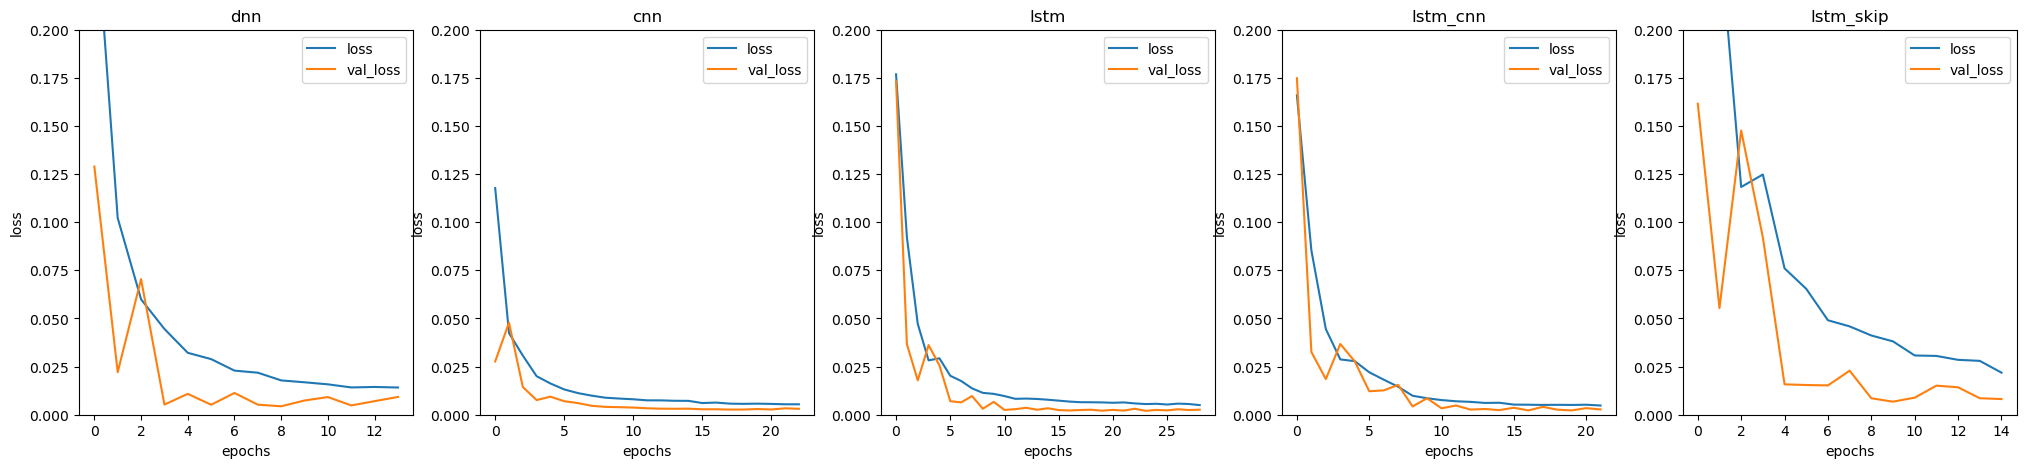

In [92]:
legend = list()

fig, axs = plt.subplots(1, 5, figsize=(25,5))

def plot_graphs(metric, val, ax, upper):
    ax.plot(val['history'].history[metric])
    ax.plot(val['history'].history[f'val_{metric}'])
    ax.set_title(key)
    ax.legend([metric, f"val_{metric}"])
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.set_ylim([0, upper])
    
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('loss', val, ax, 0.2)
print("Loss Curves")

MAE Curves


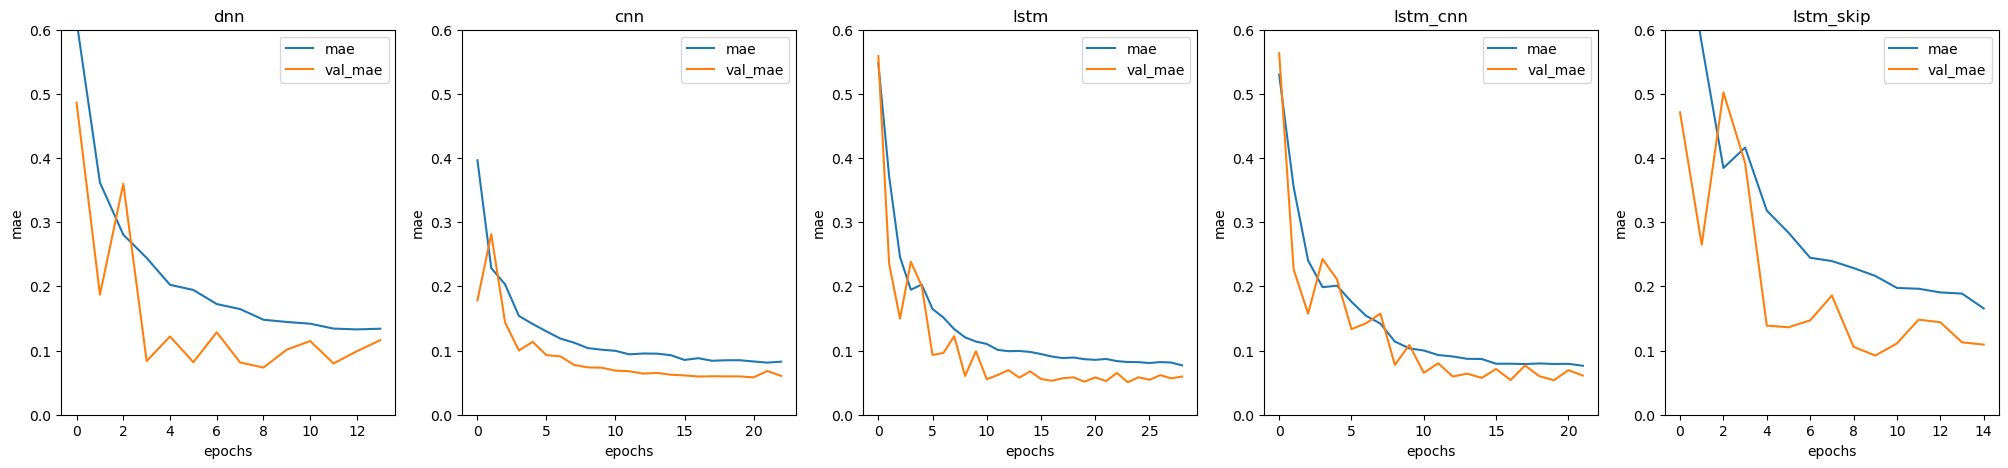

In [93]:
print("MAE Curves")
fig, axs = plt.subplots(1, 5, figsize=(25,5))
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('mae', val, ax, 0.6)

In [95]:
names = list()
performance = list()

for key, value in model_configs.items():
    names.append(key)
    mae = value['model'].evaluate(value['test_ds'])
    performance.append(mae[1])
    
performance_df = pd.DataFrame(performance, index=names, columns=['mae'])
performance_df['error_mw'] = performance_df['mae'] * df['meantemp'].mean()
print(performance_df) 

2/2 [==============================] - 0s 24ms/step - loss: 0.0068 - mae: 0.0922
                mae  error_mw
dnn        0.073519  1.874398
cnn        0.059919  1.527665
lstm       0.050642  1.291144
lstm_cnn   0.053929  1.374938
lstm_skip  0.092243  2.351793


2/2 [==============================] - 0s 32ms/step


2/2 [==============================] - 0s 25ms/step
First Two Weeks of Predictions


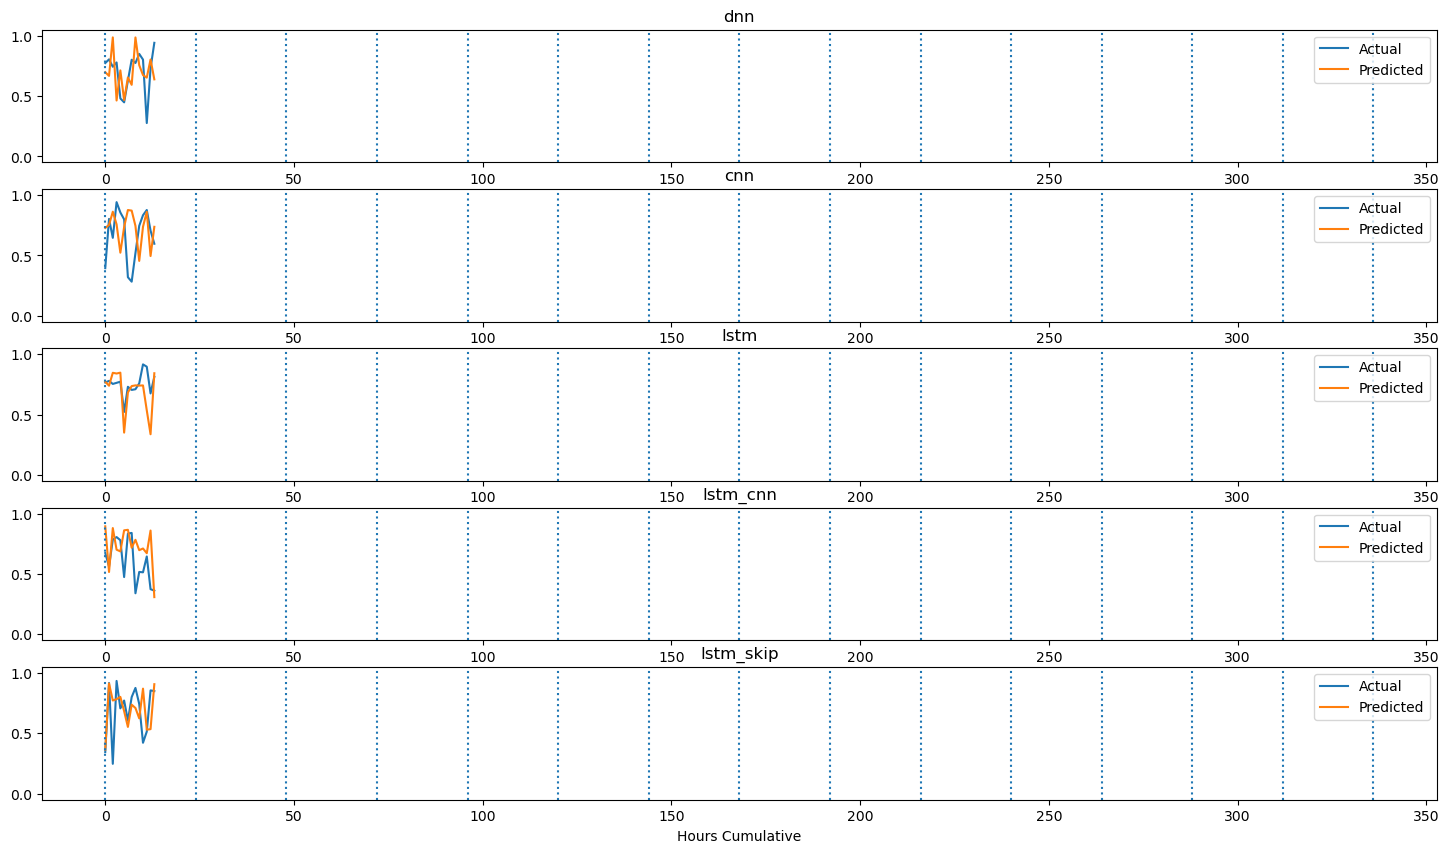

In [96]:
fig, axs = plt.subplots(5, 1, figsize=(18, 10))
days = 14

vline = np.linspace(0, days*24, days+1)

for (key, val), ax in zip(model_configs.items(), axs):

    test = val['test_ds']
    preds = val['model'].predict(test)

    xbatch, ybatch = iter(test).get_next()

    ax.plot(ybatch.numpy()[:days].reshape(-1))
    ax.plot(preds[:days].reshape(-1))
    ax.set_title(key)
    ax.vlines(vline, ymin=0, ymax=1, linestyle='dotted', transform = ax.get_xaxis_transform())
    ax.legend(["Actual", "Predicted"])

plt.xlabel("Hours Cumulative")
print('First Two Weeks of Predictions')